
#**RSNA BREAST CANCER DETECTION**
BETHUEL Elouan - GHRAIZI Marwa - SALAUN Nicolas <br>
AIAO - M2 Bioinformatique - 2023/2024


#**Dependencies**

In [ ]:
from google.colab import drive
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.utils import image_dataset_from_directory
from keras.applications.efficientnet import EfficientNetB2
from keras.applications.efficientnet import EfficientNetB4
from keras.applications.efficientnet import EfficientNetB6
from keras.applications.efficientnet_v2 import EfficientNetV2S
from keras.applications import DenseNet121
from keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Input, Conv2D, MaxPooling2D, Flatten, Activation
import tensorflow as tf
from keras.applications.resnet50 import ResNet50
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

#**Importing Datasets from Drive**

In [ ]:
drive.mount('/content/drive', force_remount = True)
!cd /content/drive/My\ Drive/AIAO

Mounted at /content/drive


##**Resolution 256**

In [ ]:
image_size = (256, 256)
batch_size = 32

In [ ]:
train_ds_256_unprocessed = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_256_unprocessed/train", seed=1337, image_size = image_size, batch_size = batch_size)
test_ds_256 = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_256_unprocessed/test", seed=1337, image_size = image_size, batch_size = batch_size, shuffle = False)

Found 1930 files belonging to 2 classes.
Found 386 files belonging to 2 classes.


In [ ]:
train_ds_256_enhanced = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_256_enhanced/train", seed=1337, image_size = image_size, batch_size = batch_size)
test_ds_256 = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_256_enhanced/test", seed=1337, image_size = image_size, batch_size = batch_size, shuffle = False)

Found 1930 files belonging to 2 classes.
Found 386 files belonging to 2 classes.


##**Resolution 512**

In [ ]:
image_size = (512, 512)
batch_size = 32

In [ ]:
train_ds_512_unprocessed = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_512_unprocessed/train", seed=1337, image_size = image_size, batch_size = batch_size)
test_ds_512 = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_512_unprocessed/test", seed=1337, image_size = image_size, batch_size = batch_size, shuffle = False)

Found 1930 files belonging to 2 classes.
Found 386 files belonging to 2 classes.


In [ ]:
train_ds_512_enhanced = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_512_enhanced/train", seed=1337, image_size = image_size, batch_size = batch_size)
test_ds_512 = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_512_enhanced/test", seed=1337, image_size = image_size, batch_size = batch_size, shuffle = False)

Found 1930 files belonging to 2 classes.
Found 386 files belonging to 2 classes.


In [ ]:
train_ds_512_augmented = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_512_augmented/train", seed=1337, image_size = image_size, batch_size = batch_size)
test_ds_512 = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_512_augmented/test", seed=1337, image_size = image_size, batch_size = batch_size, shuffle = False)

Found 3860 files belonging to 2 classes.
Found 386 files belonging to 2 classes.


In [ ]:
# resizing images for B4
image_size = (380, 380)
batch_size = 32

In [ ]:
train_ds_380_unprocessed = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_512_unprocessed/train", seed=1337, image_size = image_size, batch_size = batch_size)
test_ds_380 = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_512_unprocessed/test", seed=1337, image_size = image_size, batch_size = batch_size, shuffle = False)

Found 1930 files belonging to 2 classes.
Found 386 files belonging to 2 classes.


In [ ]:
train_ds_380_enhanced = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_512_enhanced/train", seed=1337, image_size = image_size, batch_size = batch_size)
test_ds_380 = image_dataset_from_directory("/content/drive/MyDrive/AIAO/model_ready_data_512_enhanced/test", seed=1337, image_size = image_size, batch_size = batch_size, shuffle = False)

Found 1930 files belonging to 2 classes.
Found 386 files belonging to 2 classes.


#**Training Functions**

In [ ]:
# common function to unfreeze models
def unfreeze_model(model, optimizer_type, nb_unfrozen_layers=20, learning_rate=1e-4):
    for layer in model.layers[-nb_unfrozen_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    if optimizer_type == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

##**EfficientNet**

Inspired by the [Keras Transfer Learning Tutorial](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)

###**EfficientNet B2**

trained on imagenet of size 260, make sure the input image resolution is appropriate

In [ ]:
def train_frozen_efficientnetB2(image_size, optimizer_type, learning_rate=1e-3, top_dropout_rate=0.2):
    with tf.device('/device:GPU:0'):

      inputs = layers.Input(shape=(image_size, image_size, 3))
      x = inputs
      model = EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet")
      model.trainable = False

      x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
      x = layers.BatchNormalization()(x)

      x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

      outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

      model = tf.keras.Model(inputs, outputs, name="EfficientNet")
      if optimizer_type == "SGD":
          optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
      else:
          optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

      model.compile(
              optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
          )

      return model

###**EfficientNet B4**

trained on imagenet of size 380, make sure the input image resolution is appropriate

In [ ]:
def train_frozen_efficientnetB4(image_size, optimizer_type, learning_rate=1e-3, top_dropout_rate=0.2):
    with tf.device('/device:GPU:0'):

      inputs = layers.Input(shape=(image_size, image_size, 3))
      x = inputs
      model = EfficientNetB4(include_top=False, input_tensor=x, weights="imagenet")
      model.trainable = False

      x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
      x = layers.BatchNormalization()(x)

      x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

      outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

      model = tf.keras.Model(inputs, outputs, name="EfficientNet")
      if optimizer_type == "SGD":
          optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
      else:
          optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

      model.compile(
              optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
          )

      return model

###**EfficientNet B6**

trained on imagenet of size 528, make sure the input image resolution is appropriate

In [ ]:
def train_frozen_efficientnetB6(image_size, optimizer_type, learning_rate=1e-3, top_dropout_rate=0.2):
    with tf.device('/device:GPU:0'):

      inputs = layers.Input(shape=(image_size, image_size, 3))
      x = inputs
      model = EfficientNetB6(include_top=False, input_tensor=x, weights="imagenet")
      model.trainable = False

      x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
      x = layers.BatchNormalization()(x)

      x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

      outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

      model = tf.keras.Model(inputs, outputs, name="EfficientNet")
      if optimizer_type == "SGD":
          optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
      else:
          optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

      model.compile(
              optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
          )

      return model

###**EfficientNet V2S**

In [ ]:
def train_frozen_efficientnetV2S(image_size, optimizer_type, learning_rate=1e-3, top_dropout_rate=0.2):
    with tf.device('/device:GPU:0'):

      inputs = layers.Input(shape=(image_size, image_size, 3))
      x = inputs
      model = EfficientNetV2S(include_top=False, input_tensor=x, weights="imagenet")
      model.trainable = False

      x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
      x = layers.BatchNormalization()(x)

      x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

      outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

      model = tf.keras.Model(inputs, outputs, name="EfficientNet")
      if optimizer_type == "SGD":
          optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
      else:
          optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

      model.compile(
              optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
          )

      return model

##**DenseNet**

In [ ]:
model = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

x = model.output

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(1024,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs = model.input, outputs = predictions)
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
optimizer = keras.optimizers.SGD(learning_rate=1e-6)

class_weight = {0: 1., 1: 3.}


# **CNN**

In [ ]:
def create_and_train_model(architecture, num_neurons, train_ds, test_ds, model_type):
    if model_type == "nnet":
        model = EfficientNetB0(weights="imagenet", include_top=False)
    else:
        model = Sequential()
    model.add(Input(shape=(256, 256, 3)))

    # Add the layers based on the architecture provided
    for layer in architecture:
        if layer == "conv":
            model.add(Conv2D(num_neurons, (3, 3), activation='relu'))
        elif layer == "maxpool":
            model.add(MaxPooling2D(pool_size=(2, 2)))
        elif layer == "dense":
            model.add(Dense(num_neurons, activation='relu'))
        else:
            raise ValueError("Invalid layer type")

    # Flatten and add the final sigmo output layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_ds, validation_data=test_ds, epochs=20, batch_size=100, verbose=0)

    # Access the labels from test and convert to list
    y_true = []
    for images, labels in test_ds:
        y_true.extend(labels.numpy())

    # Predict labels and calculate F1 score
    y_pred = model.predict(test_ds).round().flatten()
    print(f"ypred : {len(y_pred)}, ytrue : {len(y_true)}")
    f1 = f1_score(y_true, y_pred)

    return model, history, f1

In [ ]:
architectures = [
    ["conv", "maxpool", "conv", "maxpool", "dense"],
    ["conv", "maxpool", "conv", "maxpool", "dense", "dense"],
    ["conv", "maxpool", "conv", "maxpool", "conv", "maxpool", "dense", "dense"],
]

In [ ]:
model_types = ["nnet"]
num_neurons_list = [32, 64, 128]

In [ ]:
best_model = None
best_f1_score = 0.0
for model_type in model_types:
    for architecture in architectures:
        for num_neurons in num_neurons_list:
            model, history, f1 = create_and_train_model(architecture, num_neurons, train_ds, test_ds, model_type)

            print(f"Model type: {model_type}, Architecture: {architecture}, Neurons: {num_neurons}, F1 Score: {f1}")

            # Update the best model if the F1 score is higher
            if f1 > best_f1_score:
                best_model = model
                best_f1_score = f1

print("Best Model F1 Score:", best_f1_score)

#**Plotting & Evaluation Metrics Functions**

In [ ]:
def plot_accuracy(hist, output_file="accuracy_evolution.png"):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig(output_file)
    plt.show()

def plot_loss(hist, output_file="loss_evolution.png"):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.savefig(output_file)
    plt.show()

In [ ]:
# F1 score calculation provided by competition
def pfbeta(labels, predictions, beta=1):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0


def evaluation_metrics(true_labels, predicted_labels):
    f1 = f1_score(true_labels, predicted_labels)
    acc = accuracy_score(true_labels, predicted_labels)
    pres = precision_score(true_labels, predicted_labels)
    rec = recall_score(true_labels, predicted_labels)
    print(f"F1 score: {f1}")
    print(f"Accuracy: {acc}")
    print(f"Precision: {acc}")
    print(f"Recall: {rec}")

def display_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    #tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


def display_roc_youden(true_labels, keras_probabilities):
    y_pred_keras = keras_probabilities.ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_labels, y_pred_keras)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    #plt.legend(loc='best')
    plt.show()

    youdens_index = np.argmax(tpr_keras - fpr_keras)
    best_threshold = thresholds_keras[youdens_index]
    print(f"The best threshold according to Youden's index is: {best_threshold}")




#**Prediction Functions**

In [ ]:
def extract_true_labels(test_dataset):
    """Returns a list of the true labels"""
    y_true = []
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
    return y_true

In [ ]:
def extract_predicted_labels(predicted_probabilities, threshold=0.5):
    """Returns a list of the predicted labels"""
    predicted_probabilities_list = predicted_probabilities.flatten()
    predicted_labels = (predicted_probabilities_list >= threshold).astype(int).tolist()
    return predicted_labels



#**Results**

##**Efficient Net B2**

### Resolution 256 Unprocessed

In [ ]:
from keras.applications.efficientnet import EfficientNetB2

model_efficientnetB2_256_unprocessed = train_frozen_efficientnetB2(256, "Adam", 1e-3, 0.2)
history_efficientnetB2_256_unprocessed = model_efficientnetB2_256_unprocessed.fit(train_ds_256_unprocessed, epochs=25, batch_size=32, validation_data=test_ds_256)

31790344/31790344 [==============================] - 2s 0us/step
Epoch 1/25
61/61 [==============================] - 827s 12s/step - loss: 0.8384 - accuracy: 0.5109 - val_loss: 0.6851 - val_accuracy: 0.5492
Epoch 2/25
61/61 [==============================] - 11s 164ms/step - loss: 0.7677 - accuracy: 0.5549 - val_loss: 0.6845 - val_accuracy: 0.5466
Epoch 3/25
61/61 [==============================] - 10s 147ms/step - loss: 0.7260 - accuracy: 0.5808 - val_loss: 0.6885 - val_accuracy: 0.5415
Epoch 4/25
61/61 [==============================] - 11s 174ms/step - loss: 0.6936 - accuracy: 0.6041 - val_loss: 0.6777 - val_accuracy: 0.5803
Epoch 5/25
61/61 [==============================] - 12s 183ms/step - loss: 0.6673 - accuracy: 0.6150 - val_loss: 0.6807 - val_accuracy: 0.5751
Epoch 6/25
61/61 [==============================] - 9s 145ms/step - loss: 0.6727 - accuracy: 0.6073 - val_loss: 0.6789 - val_accuracy: 0.5596
Epoch 7/25
61/61 [==============================] - 10s 144ms/step - loss: 0.65

In [ ]:
model_efficientnetB2_256_unprocessed = unfreeze_model(model_efficientnetB2_256_unprocessed, "Adam", 20, 1e-4)
history_efficientnetB2_256_unprocessed = model_efficientnetB2_256_unprocessed.fit(train_ds_256_unprocessed, epochs=15, batch_size=32, validation_data=test_ds_256)

Epoch 1/15
61/61 [==============================] - 26s 192ms/step - loss: 0.6274 - accuracy: 0.6642 - val_loss: 0.7078 - val_accuracy: 0.5829
Epoch 2/15
61/61 [==============================] - 10s 158ms/step - loss: 0.5882 - accuracy: 0.6772 - val_loss: 0.7178 - val_accuracy: 0.5777
Epoch 3/15
61/61 [==============================] - 11s 171ms/step - loss: 0.5495 - accuracy: 0.7135 - val_loss: 0.7073 - val_accuracy: 0.5907
Epoch 4/15
61/61 [==============================] - 10s 156ms/step - loss: 0.5099 - accuracy: 0.7446 - val_loss: 0.7166 - val_accuracy: 0.6010
Epoch 5/15
61/61 [==============================] - 10s 154ms/step - loss: 0.5105 - accuracy: 0.7399 - val_loss: 0.7238 - val_accuracy: 0.5881
Epoch 6/15
61/61 [==============================] - 11s 170ms/step - loss: 0.4871 - accuracy: 0.7642 - val_loss: 0.7970 - val_accuracy: 0.5699
Epoch 7/15
61/61 [==============================] - 10s 149ms/step - loss: 0.4613 - accuracy: 0.7813 - val_loss: 0.7643 - val_accuracy: 0.5855

In [ ]:
model_efficientnetB2_256_unprocessed.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0][

In [ ]:
model_efficientnetB2_256_unprocessed.save("/content/drive/MyDrive/AIAO/model_efficientnetB2_256_unprocessed_Adam_10-3_Adam_10-4.keras")

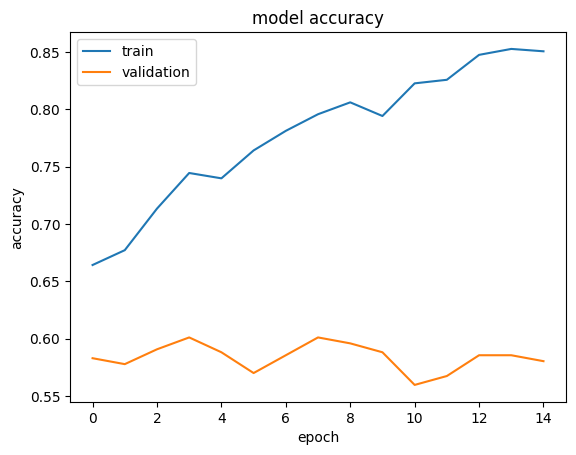

In [ ]:
plot_accuracy(history_efficientnetB2_256_unprocessed)

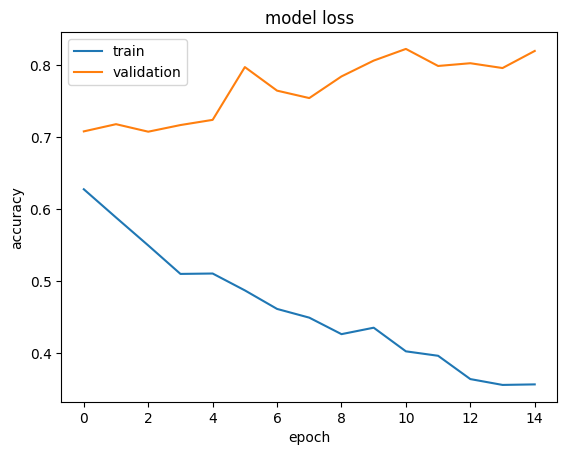

In [ ]:
plot_loss(history_efficientnetB2_256_unprocessed)

In [ ]:
#model_efficientnetB2_256_unprocessed = tf.keras.models.load_model('/content/drive/MyDrive/AIAO/training_results_256/model_efficientnetB2_256_unprocessed_Adam_10-3_Adam_10-4.keras')

In [ ]:
unprocessed_256_predicted_probabilities = model_efficientnetB2_256_unprocessed.predict(test_ds_256)
unprocessed_256_true_labels = extract_true_labels(test_ds_256)

13/13 [==============================] - 5s 120ms/step


In [ ]:
unprocessed_256_predicted_labels = extract_predicted_labels(unprocessed_256_predicted_probabilities, 0.5)

In [ ]:
evaluation_metrics(unprocessed_256_true_labels, unprocessed_256_predicted_labels)

F1 score: 0.5621621621621622
Accuracy: 0.5803108808290155
Precision: 0.5803108808290155
Recall: 0.538860103626943


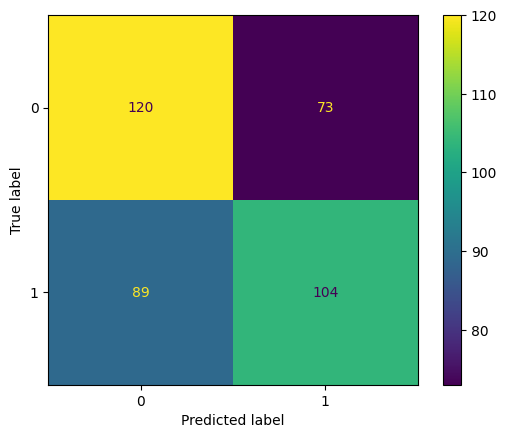

In [ ]:
display_confusion_matrix(unprocessed_256_true_labels, unprocessed_256_predicted_labels)

### Resolution 256 enhanced

In [ ]:
model_efficientnetB2_256_enhanced = train_frozen_efficientnetB2(256, "Adam", 1e-3, 0.2)
history_efficientnetB2_256_enhanced = model_efficientnetB2_256_enhanced.fit(train_ds_256_enhanced, epochs=25, batch_size=32, validation_data=test_ds_256)

31790344/31790344 [==============================] - 0s 0us/step
Epoch 1/25
61/61 [==============================] - 221s 3s/step - loss: 0.8459 - accuracy: 0.5093 - val_loss: 0.6898 - val_accuracy: 0.5622
Epoch 2/25
61/61 [==============================] - 9s 144ms/step - loss: 0.7363 - accuracy: 0.5855 - val_loss: 0.6828 - val_accuracy: 0.5699
Epoch 3/25
61/61 [==============================] - 9s 140ms/step - loss: 0.7024 - accuracy: 0.6026 - val_loss: 0.6872 - val_accuracy: 0.5855
Epoch 4/25
61/61 [==============================] - 9s 145ms/step - loss: 0.6840 - accuracy: 0.6109 - val_loss: 0.6860 - val_accuracy: 0.5959
Epoch 5/25
61/61 [==============================] - 9s 143ms/step - loss: 0.6893 - accuracy: 0.5979 - val_loss: 0.6870 - val_accuracy: 0.5855
Epoch 6/25
61/61 [==============================] - 10s 160ms/step - loss: 0.6746 - accuracy: 0.6238 - val_loss: 0.7130 - val_accuracy: 0.5596
Epoch 7/25
61/61 [==============================] - 9s 140ms/step - loss: 0.6528 - 

In [ ]:
model_efficientnetB2_256_enhanced = unfreeze_model(model_efficientnetB2_256_enhanced, "Adam", 20, 1e-4)
history_efficientnetB2_256_enhanced = model_efficientnetB2_256_enhanced.fit(train_ds_256_enhanced, epochs=15, batch_size=32, validation_data=test_ds_256)

Epoch 1/15
61/61 [==============================] - 23s 187ms/step - loss: 0.5982 - accuracy: 0.6782 - val_loss: 0.7830 - val_accuracy: 0.5492
Epoch 2/15
61/61 [==============================] - 10s 152ms/step - loss: 0.5675 - accuracy: 0.6943 - val_loss: 0.7753 - val_accuracy: 0.5596
Epoch 3/15
61/61 [==============================] - 10s 152ms/step - loss: 0.5638 - accuracy: 0.7052 - val_loss: 0.7486 - val_accuracy: 0.5674
Epoch 4/15
61/61 [==============================] - 10s 150ms/step - loss: 0.5359 - accuracy: 0.7052 - val_loss: 0.7564 - val_accuracy: 0.5544
Epoch 5/15
61/61 [==============================] - 10s 149ms/step - loss: 0.5228 - accuracy: 0.7347 - val_loss: 0.7942 - val_accuracy: 0.5492
Epoch 6/15
61/61 [==============================] - 10s 154ms/step - loss: 0.5029 - accuracy: 0.7440 - val_loss: 0.7897 - val_accuracy: 0.5699
Epoch 7/15
61/61 [==============================] - 10s 153ms/step - loss: 0.4890 - accuracy: 0.7648 - val_loss: 0.8017 - val_accuracy: 0.5699

In [ ]:
model_efficientnetB2_256_enhanced.save("/content/drive/MyDrive/AIAO/training_results_256/model_efficientnetB2_256_enhanced_Adam_10-3_Adam_10-4.keras")

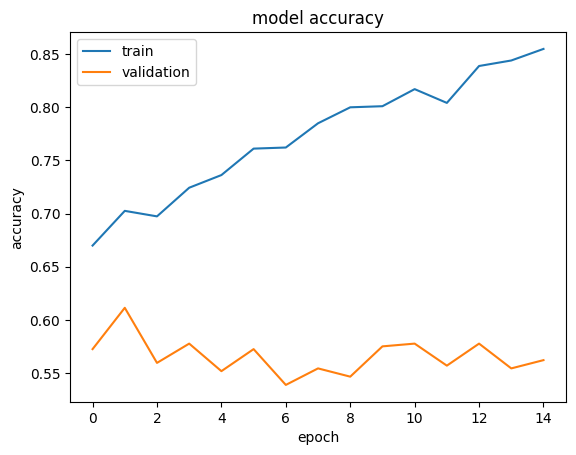

In [ ]:
plot_accuracy(history_efficientnetB2_256_enhanced)

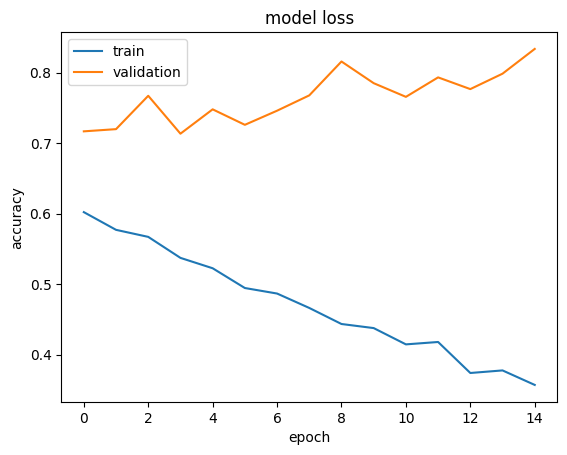

In [ ]:
plot_loss(history_efficientnetB2_256_enhanced)

In [ ]:
enhanced_256_predicted_probabilities = model_efficientnetB2_256_enhanced.predict(test_ds_256)
enhanced_256_true_labels = extract_true_labels(test_ds_256)

13/13 [==============================] - 8s 133ms/step


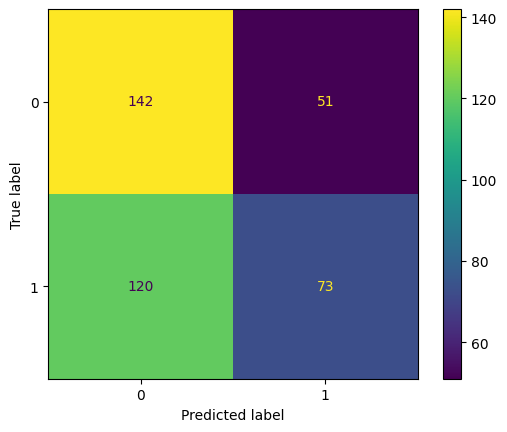

In [ ]:
enhanced_256_predicted_labels = extract_predicted_labels(enhanced_256_predicted_probabilities, 0.5)

In [ ]:
evaluation_metrics(enhanced_256_true_labels, enhanced_256_predicted_labels)

F1 score: 0.48318042813455664
Accuracy: 0.5621761658031088
Precision: 0.5621761658031088
Recall: 0.40932642487046633


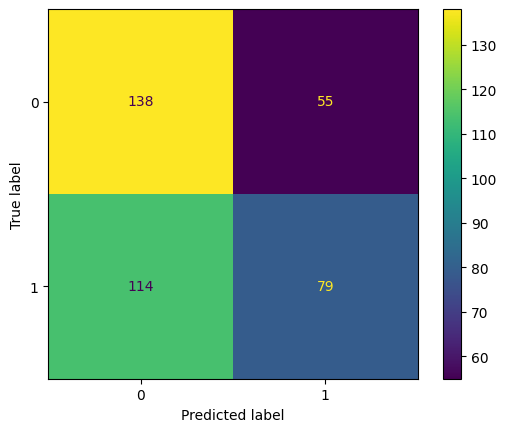

In [ ]:
display_confusion_matrix(enhanced_256_true_labels, enhanced_256_predicted_labels)

##**Efficient Net B4**

###Resolution 380 unprocessed

In [ ]:
model_efficientnetB4_380_unprocessed = train_frozen_efficientnetB4(380, "Adam", 1e-3, 0.2)
history_efficientnetB4_380_unprocessed = model_efficientnetB4_380_unprocessed.fit(train_ds_380_unprocessed, epochs=25, batch_size=32, validation_data=test_ds_380)

71686520/71686520 [==============================] - 0s 0us/step
Epoch 1/25
61/61 [==============================] - 399s 6s/step - loss: 0.8530 - accuracy: 0.5140 - val_loss: 0.6838 - val_accuracy: 0.5674
Epoch 2/25
61/61 [==============================] - 33s 531ms/step - loss: 0.7369 - accuracy: 0.5653 - val_loss: 0.6752 - val_accuracy: 0.5803
Epoch 3/25
61/61 [==============================] - 34s 543ms/step - loss: 0.7249 - accuracy: 0.5881 - val_loss: 0.6695 - val_accuracy: 0.5777
Epoch 4/25
61/61 [==============================] - 34s 551ms/step - loss: 0.6785 - accuracy: 0.6166 - val_loss: 0.6562 - val_accuracy: 0.6140
Epoch 5/25
61/61 [==============================] - 34s 550ms/step - loss: 0.6910 - accuracy: 0.6041 - val_loss: 0.6618 - val_accuracy: 0.5544
Epoch 6/25
61/61 [==============================] - 34s 552ms/step - loss: 0.6760 - accuracy: 0.6130 - val_loss: 0.6630 - val_accuracy: 0.5855
Epoch 7/25
61/61 [==============================] - 34s 547ms/step - loss: 0.64

In [ ]:
model_efficientnetB4_380_unprocessed = unfreeze_model(model_efficientnetB4_380_unprocessed, "Adam", 20, 1e-4)
history_efficientnetB4_380_unprocessed = model_efficientnetB4_380_unprocessed.fit(train_ds_380_unprocessed, epochs=20, batch_size=32, validation_data=test_ds_380)

Epoch 1/20
61/61 [==============================] - 54s 631ms/step - loss: 0.6169 - accuracy: 0.6694 - val_loss: 0.6969 - val_accuracy: 0.6036
Epoch 2/20
61/61 [==============================] - 36s 571ms/step - loss: 0.5689 - accuracy: 0.7062 - val_loss: 0.6814 - val_accuracy: 0.6140
Epoch 3/20
61/61 [==============================] - 35s 567ms/step - loss: 0.5233 - accuracy: 0.7358 - val_loss: 0.7145 - val_accuracy: 0.5803
Epoch 4/20
61/61 [==============================] - 36s 575ms/step - loss: 0.5147 - accuracy: 0.7326 - val_loss: 0.7514 - val_accuracy: 0.6166
Epoch 5/20
61/61 [==============================] - 36s 573ms/step - loss: 0.4929 - accuracy: 0.7565 - val_loss: 0.7123 - val_accuracy: 0.6088
Epoch 6/20
61/61 [==============================] - 36s 574ms/step - loss: 0.4718 - accuracy: 0.7663 - val_loss: 0.7738 - val_accuracy: 0.5777
Epoch 7/20
61/61 [==============================] - 36s 577ms/step - loss: 0.4520 - accuracy: 0.7865 - val_loss: 0.7615 - val_accuracy: 0.5933

In [ ]:
model_efficientnetB4_380_unprocessed.save("/content/drive/MyDrive/AIAO/training_results_512/model_efficientnetB4_380_unprocessed_Adam_10-3_Adam_10-4.keras")

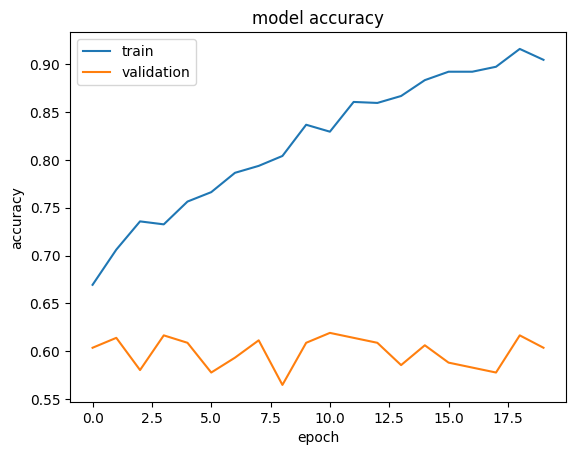

In [ ]:
plot_accuracy(history_efficientnetB4_380_unprocessed)

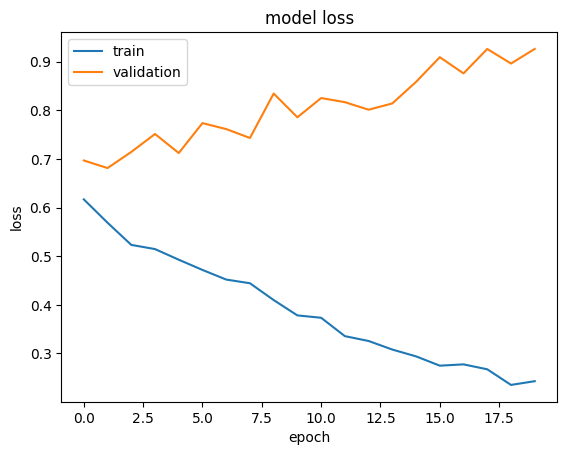

In [ ]:
plot_loss(history_efficientnetB4_380_unprocessed)

In [ ]:
#model_efficientnetB4_380_unprocessed = tf.keras.models.load_model('/content/drive/MyDrive/AIAO/training_results_512/model_efficientnetB4_380_unprocessed_Adam_10-3_Adam_10-4.keras')

In [ ]:
unprocessed_380_predicted_probabilities = model_efficientnetB4_380_unprocessed.predict(test_ds_380)
unprocessed_380_true_labels = extract_true_labels(test_ds_380)

13/13 [==============================] - 8s 432ms/step


In [ ]:
unprocessed_380_predicted_labels = extract_predicted_labels(unprocessed_380_predicted_probabilities, 0.5)

In [ ]:
evaluation_metrics(unprocessed_380_true_labels, unprocessed_380_predicted_labels)

F1 score: 0.5641025641025641
Accuracy: 0.6036269430051814
Precision: 0.6036269430051814
Recall: 0.5129533678756477


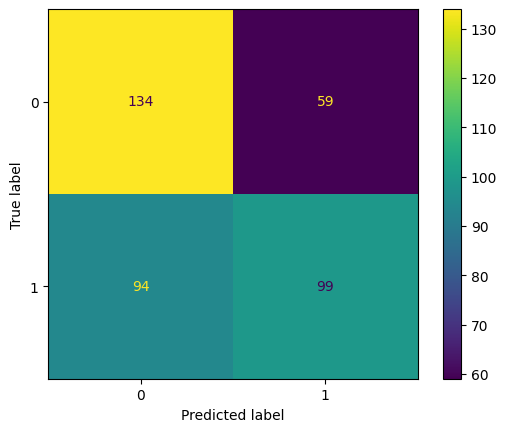

In [ ]:
display_confusion_matrix(unprocessed_380_true_labels, unprocessed_380_predicted_labels)

###Resolution 380 enhanced

In [ ]:
model_efficientnetB4_380_enhanced = train_frozen_efficientnetB4(380, "Adam", 1e-3, 0.2)
history_efficientnetB4_380_enhanced = model_efficientnetB4_380_enhanced.fit(train_ds_380_enhanced, epochs=25, batch_size=32, validation_data=test_ds_380)

71686520/71686520 [==============================] - 1s 0us/step
Epoch 1/25
61/61 [==============================] - 559s 8s/step - loss: 0.8257 - accuracy: 0.5332 - val_loss: 0.6879 - val_accuracy: 0.5725
Epoch 2/25
61/61 [==============================] - 39s 629ms/step - loss: 0.7469 - accuracy: 0.5751 - val_loss: 0.6797 - val_accuracy: 0.5777
Epoch 3/25
61/61 [==============================] - 35s 565ms/step - loss: 0.7147 - accuracy: 0.5959 - val_loss: 0.6739 - val_accuracy: 0.5881
Epoch 4/25
61/61 [==============================] - 39s 630ms/step - loss: 0.6900 - accuracy: 0.5979 - val_loss: 0.6691 - val_accuracy: 0.5959
Epoch 5/25
61/61 [==============================] - 40s 636ms/step - loss: 0.6824 - accuracy: 0.6026 - val_loss: 0.6708 - val_accuracy: 0.6062
Epoch 6/25
61/61 [==============================] - 34s 549ms/step - loss: 0.6511 - accuracy: 0.6378 - val_loss: 0.6736 - val_accuracy: 0.6218
Epoch 7/25
61/61 [==============================] - 35s 549ms/step - loss: 0.63

In [ ]:
model_efficientnetB4_380_enhanced = unfreeze_model(model_efficientnetB4_380_enhanced, "Adam", 20, 1e-4)
history_efficientnetB4_380_enhanced = model_efficientnetB4_380_enhanced.fit(train_ds_380_enhanced, epochs=20, batch_size=32, validation_data=test_ds_380)

Epoch 1/20
61/61 [==============================] - 56s 634ms/step - loss: 0.6053 - accuracy: 0.6756 - val_loss: 0.7261 - val_accuracy: 0.5907
Epoch 2/20
61/61 [==============================] - 35s 563ms/step - loss: 0.5628 - accuracy: 0.7067 - val_loss: 0.7290 - val_accuracy: 0.5933
Epoch 3/20
61/61 [==============================] - 37s 589ms/step - loss: 0.5345 - accuracy: 0.7290 - val_loss: 0.7563 - val_accuracy: 0.5674
Epoch 4/20
61/61 [==============================] - 36s 576ms/step - loss: 0.5039 - accuracy: 0.7585 - val_loss: 0.8228 - val_accuracy: 0.5829
Epoch 5/20
61/61 [==============================] - 41s 657ms/step - loss: 0.4887 - accuracy: 0.7549 - val_loss: 0.7872 - val_accuracy: 0.5803
Epoch 6/20
61/61 [==============================] - 41s 655ms/step - loss: 0.4675 - accuracy: 0.7855 - val_loss: 0.9261 - val_accuracy: 0.5337
Epoch 7/20
61/61 [==============================] - 41s 662ms/step - loss: 0.4481 - accuracy: 0.7865 - val_loss: 0.8214 - val_accuracy: 0.5777

In [ ]:
model_efficientnetB4_380_enhanced.save("/content/drive/MyDrive/AIAO/training_results_512/model_efficientnetB4_380_enhanced_Adam_10-3_Adam_10-4.keras")

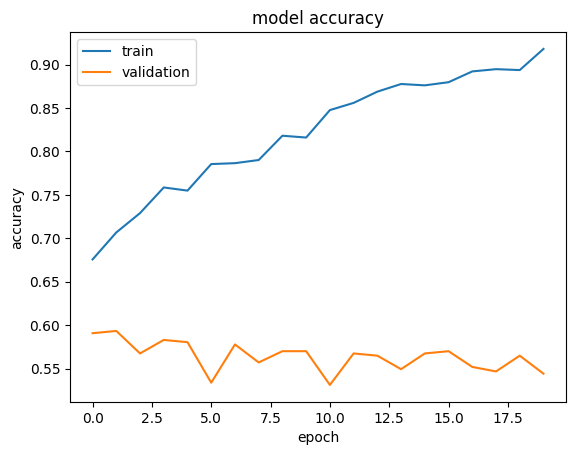

In [ ]:
plot_accuracy(history_efficientnetB4_380_enhanced)

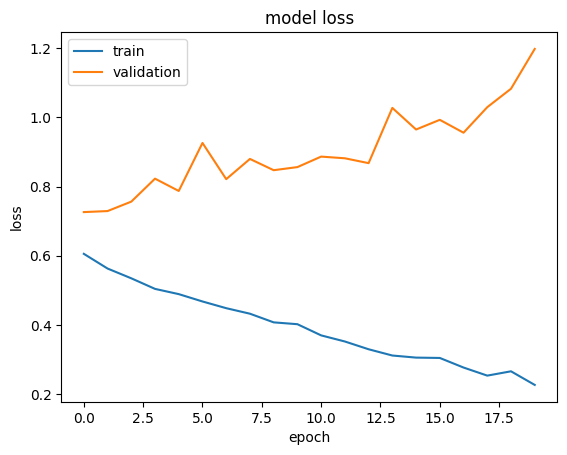

In [ ]:
plot_loss(history_efficientnetB4_380_enhanced)

In [ ]:
#model_efficientnetB4_380_enhanced = tf.keras.models.load_model('/content/drive/MyDrive/AIAO/training_results_512/model_efficientnetB4_380_enhanced_Adam_10-3_Adam_10-4.keras')

In [ ]:
enhanced_380_predicted_probabilities = model_efficientnetB4_380_enhanced.predict(test_ds_380)
enhanced_380_true_labels = extract_true_labels(test_ds_380)

13/13 [==============================] - 8s 409ms/step


In [ ]:
enhanced_380_predicted_labels = extract_predicted_labels(enhanced_380_predicted_probabilities, 0.5)

In [ ]:
evaluation_metrics(enhanced_380_true_labels, enhanced_380_predicted_labels)

F1 score: 0.33834586466165417
Accuracy: 0.5440414507772021
Precision: 0.5440414507772021
Recall: 0.23316062176165803


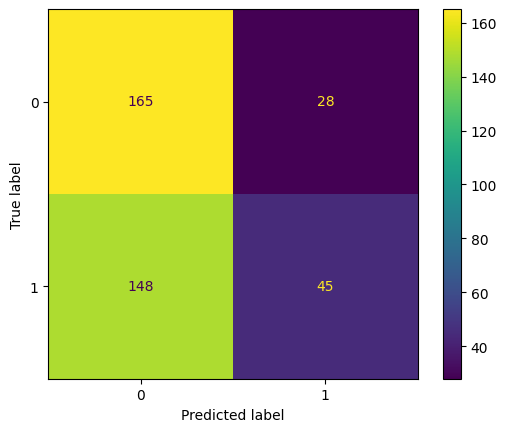

In [ ]:
display_confusion_matrix(enhanced_380_true_labels, enhanced_380_predicted_labels)

##**Efficient Net B6**

### Resolution 512 unprocessed

In [ ]:
model_efficientnetB6_512_unprocessed = train_frozen_efficientnetB6(512, "Adam", 1e-3, 0.2)
history_efficientnetB6_512_unprocessed = model_efficientnetB6_512_unprocessed.fit(train_ds_512_unprocessed, epochs=25, batch_size=32, validation_data=test_ds_512)

165234480/165234480 [==============================] - 1s 0us/step
Epoch 1/25
61/61 [==============================] - 522s 7s/step - loss: 0.8057 - accuracy: 0.5383 - val_loss: 0.6857 - val_accuracy: 0.5570
Epoch 2/25
61/61 [==============================] - 108s 2s/step - loss: 0.7496 - accuracy: 0.5648 - val_loss: 0.6851 - val_accuracy: 0.5596
Epoch 3/25
61/61 [==============================] - 110s 2s/step - loss: 0.7095 - accuracy: 0.5902 - val_loss: 0.6861 - val_accuracy: 0.5544
Epoch 4/25
61/61 [==============================] - 110s 2s/step - loss: 0.6927 - accuracy: 0.6052 - val_loss: 0.6779 - val_accuracy: 0.5881
Epoch 5/25
61/61 [==============================] - 110s 2s/step - loss: 0.6893 - accuracy: 0.6073 - val_loss: 0.6869 - val_accuracy: 0.5881
Epoch 6/25
61/61 [==============================] - 107s 2s/step - loss: 0.6768 - accuracy: 0.6218 - val_loss: 0.6817 - val_accuracy: 0.5984
Epoch 7/25
61/61 [==============================] - 107s 2s/step - loss: 0.6571 - accur

In [ ]:
model_efficientnetB6_512_unprocessed = unfreeze_model(model_efficientnetB6_512_unprocessed, "Adam", 20, 1e-4)
history_efficientnetB6_512_unprocessed = model_efficientnetB6_512_unprocessed.fit(train_ds_512_unprocessed, epochs=20, batch_size=32, validation_data=test_ds_512)

Epoch 1/20
61/61 [==============================] - 132s 2s/step - loss: 0.6430 - accuracy: 0.6534 - val_loss: 0.7961 - val_accuracy: 0.5285
Epoch 2/20
61/61 [==============================] - 110s 2s/step - loss: 0.5575 - accuracy: 0.7254 - val_loss: 0.7316 - val_accuracy: 0.5959
Epoch 3/20
61/61 [==============================] - 110s 2s/step - loss: 0.5968 - accuracy: 0.6756 - val_loss: 0.7235 - val_accuracy: 0.5881
Epoch 4/20
61/61 [==============================] - 111s 2s/step - loss: 0.5437 - accuracy: 0.7171 - val_loss: 0.7677 - val_accuracy: 0.5544
Epoch 5/20
61/61 [==============================] - 111s 2s/step - loss: 0.5200 - accuracy: 0.7368 - val_loss: 0.7670 - val_accuracy: 0.5725
Epoch 6/20
61/61 [==============================] - 111s 2s/step - loss: 0.5204 - accuracy: 0.7311 - val_loss: 0.7887 - val_accuracy: 0.5751
Epoch 7/20
61/61 [==============================] - 111s 2s/step - loss: 0.4985 - accuracy: 0.7684 - val_loss: 0.7749 - val_accuracy: 0.5907
Epoch 8/20
61

In [ ]:
model_efficientnetB6_512_unprocessed.save("/content/drive/MyDrive/marwa/AIAO/training_results_512/model_efficientnetB6_512_unprocessed_Adam_10-3_Adam_10-4.keras")

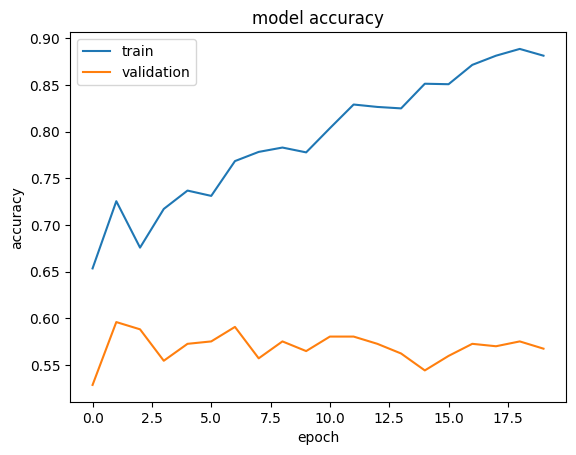

In [ ]:
plot_accuracy(history_efficientnetB6_512_unprocessed)

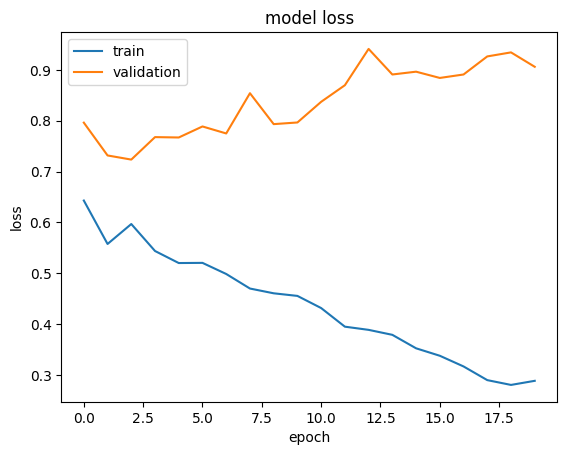

In [ ]:
plot_loss(history_efficientnetB6_512_unprocessed)

In [ ]:
#model_efficientnetB6_512_unprocessed = tf.keras.models.load_model('/content/drive/MyDrive/AIAO/training_results_512/model_efficientnetB6_512_unprocessed_Adam_10-3_Adam_10-4.keras')

In [ ]:
unprocessed_512_predicted_probabilities = model_efficientnetB6_512_unprocessed.predict(test_ds_512)
unprocessed_512_true_labels = extract_true_labels(test_ds_512)

13/13 [==============================] - 20s 1s/step


In [ ]:
unprocessed_512_predicted_labels = extract_predicted_labels(unprocessed_512_predicted_probabilities, 0.5)

In [ ]:
evaluation_metrics(unprocessed_512_true_labels, unprocessed_512_predicted_labels)

F1 score: 0.579345088161209
Accuracy: 0.5673575129533679
Precision: 0.5673575129533679
Recall: 0.5958549222797928


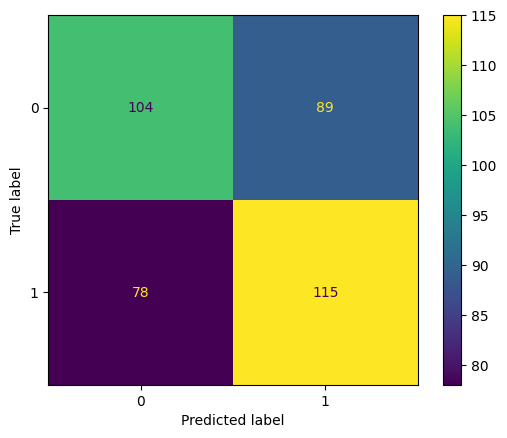

In [ ]:
display_confusion_matrix(unprocessed_512_true_labels, unprocessed_512_predicted_labels)

### Resolution 512 enhanced

In [ ]:
model_efficientnetB6_512_enhanced = train_frozen_efficientnetB6(512, "Adam", 1e-3, 0.2)
history_efficientnetB6_512_enhanced = model_efficientnetB6_512_enhanced.fit(train_ds_512_enhanced, epochs=25, batch_size=32, validation_data=test_ds_512)

165234480/165234480 [==============================] - 2s 0us/step
Epoch 1/25
61/61 [==============================] - 376s 5s/step - loss: 0.8041 - accuracy: 0.5440 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/25
61/61 [==============================] - 106s 2s/step - loss: 0.7295 - accuracy: 0.5632 - val_loss: 0.6916 - val_accuracy: 0.5285
Epoch 3/25
61/61 [==============================] - 110s 2s/step - loss: 0.7022 - accuracy: 0.5886 - val_loss: 0.6844 - val_accuracy: 0.5570
Epoch 4/25
61/61 [==============================] - 107s 2s/step - loss: 0.6836 - accuracy: 0.6124 - val_loss: 0.6920 - val_accuracy: 0.5518
Epoch 5/25
61/61 [==============================] - 106s 2s/step - loss: 0.6934 - accuracy: 0.6187 - val_loss: 0.6950 - val_accuracy: 0.5363
Epoch 6/25
61/61 [==============================] - 110s 2s/step - loss: 0.6746 - accuracy: 0.6202 - val_loss: 0.7000 - val_accuracy: 0.5544
Epoch 7/25
61/61 [==============================] - 106s 2s/step - loss: 0.6612 - accur

In [ ]:
model_efficientnetB6_512_enhanced = unfreeze_model(model_efficientnetB6_512_enhanced, "Adam", 20, 1e-4)
history_efficientnetB6_512_enhanced = model_efficientnetB6_512_enhanced.fit(train_ds_512_enhanced, epochs=15, batch_size=32, validation_data=test_ds_512)

Epoch 1/15
61/61 [==============================] - 136s 2s/step - loss: 0.6168 - accuracy: 0.6762 - val_loss: 0.8111 - val_accuracy: 0.5337
Epoch 2/15
61/61 [==============================] - 112s 2s/step - loss: 0.5411 - accuracy: 0.7233 - val_loss: 1.0249 - val_accuracy: 0.5104
Epoch 3/15
61/61 [==============================] - 112s 2s/step - loss: 0.5280 - accuracy: 0.7383 - val_loss: 0.8336 - val_accuracy: 0.5466
Epoch 4/15
61/61 [==============================] - 112s 2s/step - loss: 0.4868 - accuracy: 0.7632 - val_loss: 0.9111 - val_accuracy: 0.4948
Epoch 5/15
61/61 [==============================] - 117s 2s/step - loss: 0.4508 - accuracy: 0.7907 - val_loss: 0.8161 - val_accuracy: 0.5440
Epoch 6/15
61/61 [==============================] - 112s 2s/step - loss: 0.4030 - accuracy: 0.8036 - val_loss: 0.8767 - val_accuracy: 0.5000
Epoch 7/15
61/61 [==============================] - 112s 2s/step - loss: 0.3820 - accuracy: 0.8316 - val_loss: 1.0524 - val_accuracy: 0.5363
Epoch 8/15
61

In [ ]:
model_efficientnetB6_512_enhanced.save("/content/drive/MyDrive/marwa/AIAO/training_results_512/model_efficientnetB6_512_enhanced_Adam_10-3_Adam_10-4.keras")

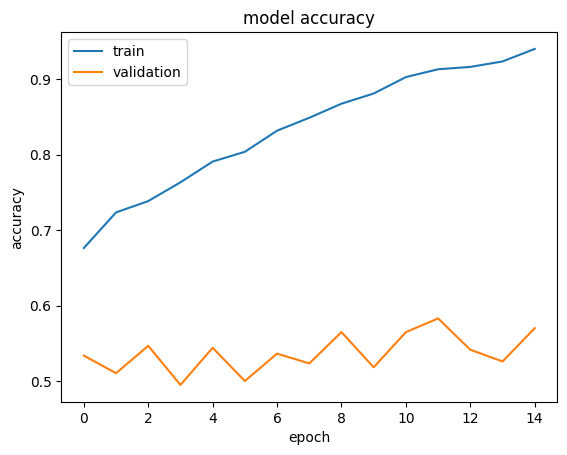

In [ ]:
plot_accuracy(history_efficientnetB6_512_enhanced)

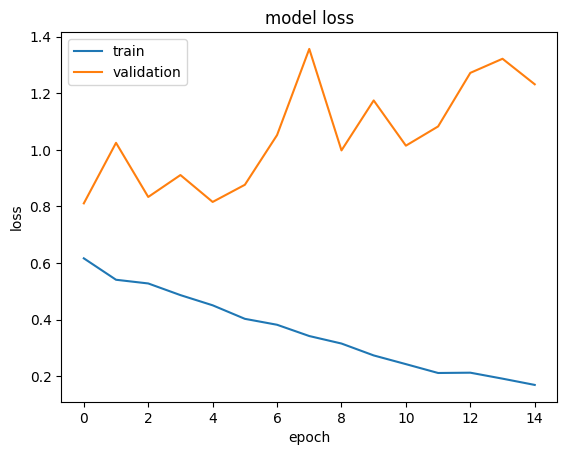

In [ ]:
plot_loss(history_efficientnetB6_512_enhanced)

In [ ]:
#model_efficientnetB6_512_enhanced = tf.keras.models.load_model('/content/drive/MyDrive/AIAO/training_results_512/model_efficientnetB6_512_enhanced_Adam_10-3_Adam_10-4.keras')

In [ ]:
enhanced_512_predicted_probabilities = model_efficientnetB6_512_enhanced.predict(test_ds_512)
enhanced_512_true_labels = extract_true_labels(test_ds_512)

13/13 [==============================] - 20s 1s/step


In [ ]:
enhanced_512_predicted_labels = extract_predicted_labels(enhanced_512_predicted_probabilities, 0.5)

In [ ]:
evaluation_metrics(enhanced_512_true_labels, enhanced_512_predicted_labels)

F1 score: 0.576530612244898
Accuracy: 0.5699481865284974
Precision: 0.5699481865284974
Recall: 0.5854922279792746


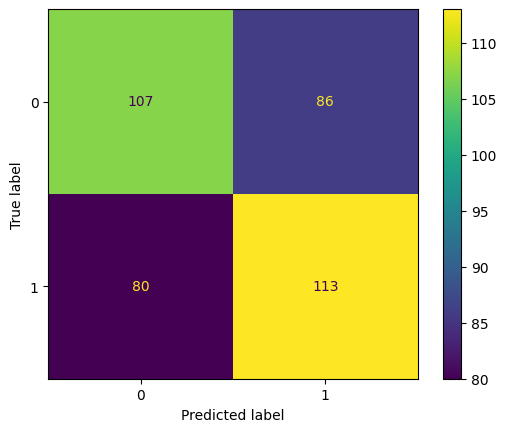

In [ ]:
display_confusion_matrix(enhanced_512_true_labels, enhanced_512_predicted_labels)

###Resolution 512 Cancerous Augmented Only

In [ ]:
model_efficientnetB6_512_augmented = train_frozen_efficientnetB6(512, "Adam", 1e-3, 0.2)
history_efficientnetB6_512_augmented = model_efficientnetB6_512_augmented.fit(train_ds_512_augmented, epochs=25, batch_size=32, validation_data=test_ds_512)

165234480/165234480 [==============================] - 5s 0us/step
Epoch 1/25
121/121 [==============================] - 480s 3s/step - loss: 0.5788 - accuracy: 0.7109 - val_loss: 0.9441 - val_accuracy: 0.5000
Epoch 2/25
121/121 [==============================] - 196s 2s/step - loss: 0.5024 - accuracy: 0.7482 - val_loss: 0.9064 - val_accuracy: 0.4974
Epoch 3/25
121/121 [==============================] - 200s 2s/step - loss: 0.4715 - accuracy: 0.7585 - val_loss: 0.8653 - val_accuracy: 0.5000
Epoch 4/25
121/121 [==============================] - 196s 2s/step - loss: 0.4738 - accuracy: 0.7648 - val_loss: 0.8542 - val_accuracy: 0.5363
Epoch 5/25
121/121 [==============================] - 196s 2s/step - loss: 0.4470 - accuracy: 0.7788 - val_loss: 0.8349 - val_accuracy: 0.5363
Epoch 6/25
121/121 [==============================] - 196s 2s/step - loss: 0.4509 - accuracy: 0.7661 - val_loss: 0.8534 - val_accuracy: 0.5285
Epoch 7/25
121/121 [==============================] - 196s 2s/step - loss: 

In [ ]:
model_efficientnetB6_512_augmented = unfreeze_model(model_efficientnetB6_512_augmented, "Adam", 20, 1e-4)
history_efficientnetB6_512_augmented = model_efficientnetB6_512_augmented.fit(train_ds_512_augmented, epochs=10, batch_size=32, validation_data=test_ds_512)

Epoch 1/10
121/121 [==============================] - 235s 2s/step - loss: 0.4053 - accuracy: 0.8052 - val_loss: 0.7580 - val_accuracy: 0.5674
Epoch 2/10
121/121 [==============================] - 208s 2s/step - loss: 0.3641 - accuracy: 0.8298 - val_loss: 0.8732 - val_accuracy: 0.5803
Epoch 3/10
121/121 [==============================] - 209s 2s/step - loss: 0.3421 - accuracy: 0.8345 - val_loss: 0.8880 - val_accuracy: 0.5881
Epoch 4/10
121/121 [==============================] - 213s 2s/step - loss: 0.2940 - accuracy: 0.8687 - val_loss: 0.8650 - val_accuracy: 0.5751
Epoch 5/10
121/121 [==============================] - 208s 2s/step - loss: 0.2702 - accuracy: 0.8811 - val_loss: 0.8919 - val_accuracy: 0.5518
Epoch 6/10
121/121 [==============================] - 213s 2s/step - loss: 0.2408 - accuracy: 0.8961 - val_loss: 0.9266 - val_accuracy: 0.5959
Epoch 7/10
121/121 [==============================] - 209s 2s/step - loss: 0.2222 - accuracy: 0.9062 - val_loss: 0.9610 - val_accuracy: 0.5829

In [ ]:
model_efficientnetB6_512_augmented.save("/content/drive/MyDrive/AIAO/training_results_512/model_efficientnetB6_512_augmented_Adam_10-3_Adam_10-4.keras")

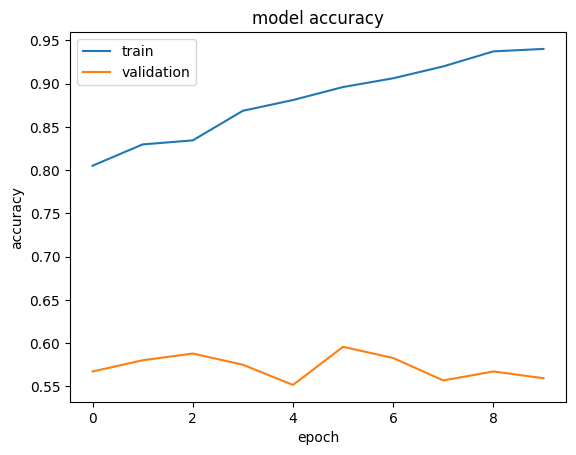

In [ ]:
plot_accuracy(history_efficientnetB6_512_augmented)

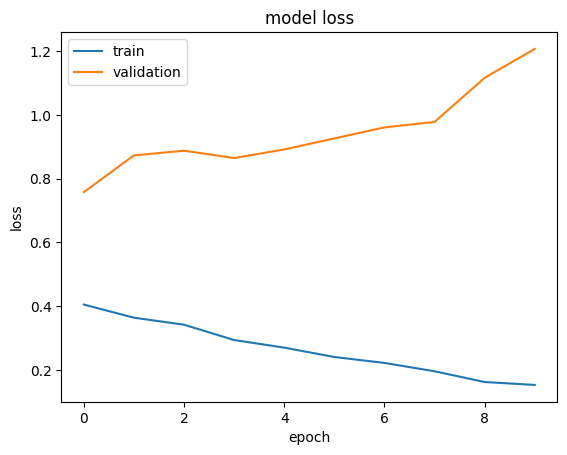

In [ ]:
plot_loss(history_efficientnetB6_512_augmented)

In [ ]:
#model_efficientnetB6_512_augmented = tf.keras.models.load_model('/content/drive/MyDrive/AIAO/training_results_512/model_efficientnetB6_512_augmented_Adam_10-3_Adam_10-4.keras')

In [ ]:
augmented_512_predicted_probabilities = model_efficientnetB6_512_augmented.predict(test_ds_512)
augmented_512_true_labels = extract_true_labels(test_ds_512)

13/13 [==============================] - 21s 1s/step


In [ ]:
augmented_512_predicted_labels = extract_predicted_labels(augmented_512_predicted_probabilities, 0.8)

In [ ]:
evaluation_metrics(augmented_512_true_labels, augmented_512_predicted_labels)

F1 score: 0.577889447236181
Accuracy: 0.5647668393782384
Precision: 0.5647668393782384
Recall: 0.5958549222797928


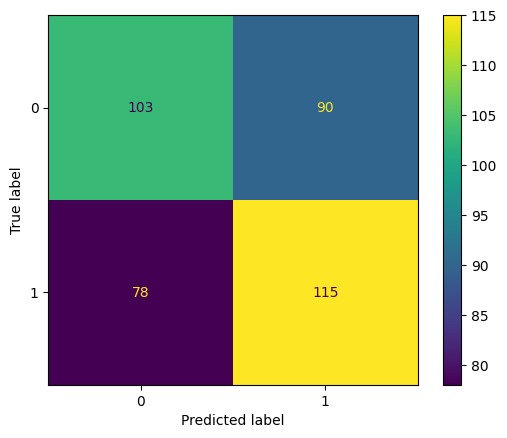

In [ ]:
display_confusion_matrix(augmented_512_true_labels, augmented_512_predicted_labels)

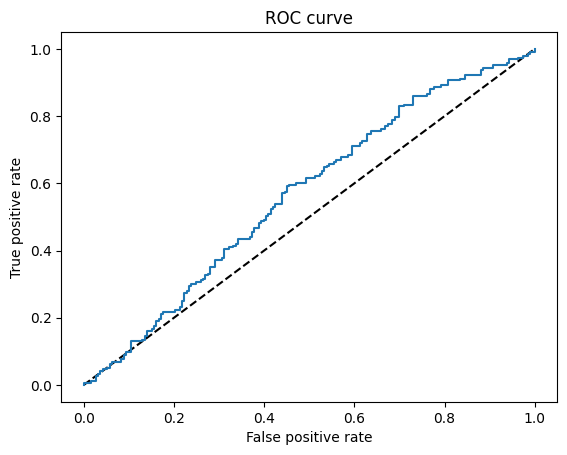

The best threshold according to Youden's index is: 0.8091253042221069


In [ ]:
display_roc_youden(augmented_512_true_labels, augmented_512_predicted_probabilities)

## **EfficientNet V2S**

### Resolution 512 unprocessed

In [ ]:
model_efficientnetV2S_512_unprocessed = train_frozen_efficientnetV2S(512, "Adam", 1e-3, 0.2)
history_efficientnetV2S_512_unprocessed = model_efficientnetV2S_512_unprocessed.fit(train_ds_512_unprocessed, epochs=25, batch_size=32, validation_data=test_ds_512)

82420632/82420632 [==============================] - 0s 0us/step
Epoch 1/25
61/61 [==============================] - 337s 4s/step - loss: 0.8289 - accuracy: 0.5052 - val_loss: 0.6932 - val_accuracy: 0.5311
Epoch 2/25
61/61 [==============================] - 54s 868ms/step - loss: 0.7490 - accuracy: 0.5679 - val_loss: 0.6848 - val_accuracy: 0.5544
Epoch 3/25
61/61 [==============================] - 49s 790ms/step - loss: 0.7469 - accuracy: 0.5699 - val_loss: 0.6785 - val_accuracy: 0.5699
Epoch 4/25
61/61 [==============================] - 50s 795ms/step - loss: 0.7041 - accuracy: 0.5860 - val_loss: 0.6734 - val_accuracy: 0.5777
Epoch 5/25
61/61 [==============================] - 50s 796ms/step - loss: 0.6883 - accuracy: 0.6088 - val_loss: 0.6661 - val_accuracy: 0.5674
Epoch 6/25
61/61 [==============================] - 50s 804ms/step - loss: 0.6795 - accuracy: 0.6026 - val_loss: 0.6697 - val_accuracy: 0.5907
Epoch 7/25
61/61 [==============================] - 49s 787ms/step - loss: 0.67

In [ ]:
model_efficientnetV2S_512_unprocessed = unfreeze_model(model_efficientnetV2S_512_unprocessed, "Adam", 20, 1e-4)
history_efficientnetV2S_512_unprocessed = model_efficientnetV2S_512_unprocessed.fit(train_ds_512_unprocessed, epochs=20, batch_size=32, validation_data=test_ds_512)

Epoch 1/20
61/61 [==============================] - 75s 930ms/step - loss: 0.6415 - accuracy: 0.6363 - val_loss: 0.7649 - val_accuracy: 0.5544
Epoch 2/20
61/61 [==============================] - 51s 817ms/step - loss: 0.6198 - accuracy: 0.6560 - val_loss: 0.6714 - val_accuracy: 0.6114
Epoch 3/20
61/61 [==============================] - 51s 809ms/step - loss: 0.6226 - accuracy: 0.6601 - val_loss: 0.6751 - val_accuracy: 0.6140
Epoch 4/20
61/61 [==============================] - 54s 865ms/step - loss: 0.5892 - accuracy: 0.6777 - val_loss: 0.6681 - val_accuracy: 0.6244
Epoch 5/20
61/61 [==============================] - 54s 865ms/step - loss: 0.5907 - accuracy: 0.6767 - val_loss: 0.6749 - val_accuracy: 0.6114
Epoch 6/20
61/61 [==============================] - 54s 865ms/step - loss: 0.5809 - accuracy: 0.6938 - val_loss: 0.6857 - val_accuracy: 0.6166
Epoch 7/20
61/61 [==============================] - 52s 829ms/step - loss: 0.5854 - accuracy: 0.6943 - val_loss: 0.7624 - val_accuracy: 0.5855

In [ ]:
model_efficientnetV2S_512_unprocessed.save("/content/drive/MyDrive/AIAO/training_results_512/model_efficientnetV2S_512_unprocessed_Adam_10-3_Adam_10-4.keras")

In [ ]:
model_efficientnetV2S_512_unprocessed = load_mod

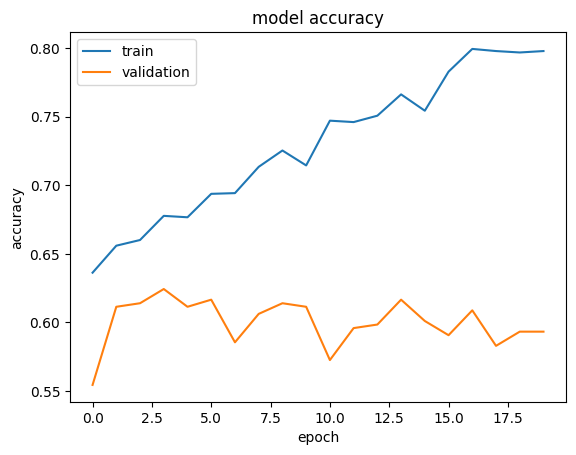

In [ ]:
plot_accuracy(history_efficientnetV2S_512_unprocessed)

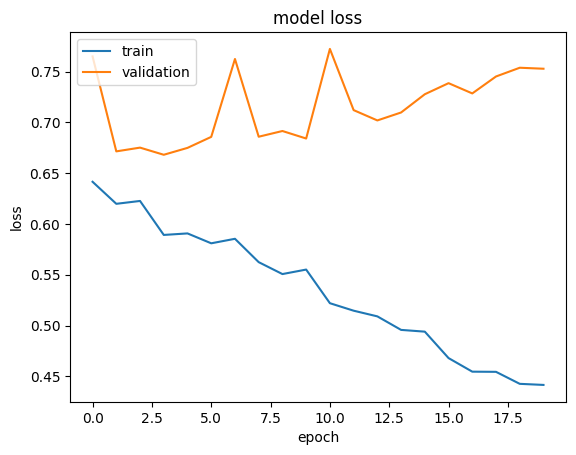

In [ ]:
plot_loss(history_efficientnetV2S_512_unprocessed)

In [ ]:
unprocessed_512_predicted_probabilities = model_efficientnetV2S_512_unprocessed.predict(test_ds_512)
unprocessed_512_true_labels = extract_true_labels(test_ds_512)

13/13 [==============================] - 10s 560ms/step


In [ ]:
unprocessed_512_predicted_labels = extract_predicted_labels(unprocessed_512_predicted_probabilities, 0.5)

In [ ]:
evaluation_metrics(unprocessed_512_true_labels, unprocessed_512_predicted_labels)

F1 score: 0.6357308584686774
Accuracy: 0.5932642487046632
Precision: 0.5932642487046632
Recall: 0.7098445595854922


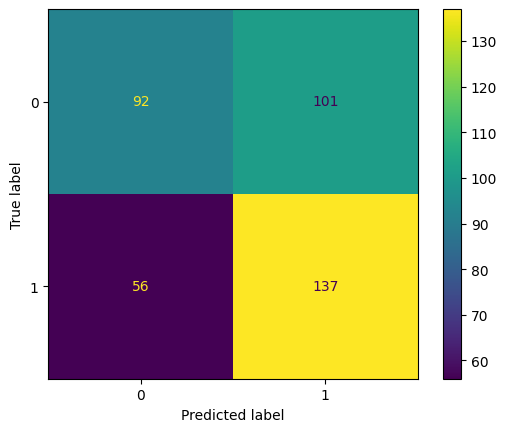

In [ ]:
display_confusion_matrix(unprocessed_512_true_labels, unprocessed_512_predicted_labels)

### Resolution 512 Enhanced

In [ ]:
model_efficientnetV2S_512_enhanced = train_frozen_efficientnetV2S(512, "Adam", 1e-3, 0.2)
history_efficientnetV2S_512_enhanced = model_efficientnetV2S_512_enhanced.fit(train_ds_512_enhanced, epochs=25, batch_size=32, validation_data=test_ds_512)

82420632/82420632 [==============================] - 0s 0us/step
Epoch 1/25
61/61 [==============================] - 263s 3s/step - loss: 0.8330 - accuracy: 0.5171 - val_loss: 0.6808 - val_accuracy: 0.5907
Epoch 2/25
61/61 [==============================] - 52s 833ms/step - loss: 0.7370 - accuracy: 0.5715 - val_loss: 0.6694 - val_accuracy: 0.5959
Epoch 3/25
61/61 [==============================] - 47s 763ms/step - loss: 0.7215 - accuracy: 0.5694 - val_loss: 0.6614 - val_accuracy: 0.5829
Epoch 4/25
61/61 [==============================] - 48s 772ms/step - loss: 0.7065 - accuracy: 0.5902 - val_loss: 0.6626 - val_accuracy: 0.5933
Epoch 5/25
61/61 [==============================] - 51s 820ms/step - loss: 0.6967 - accuracy: 0.5974 - val_loss: 0.6538 - val_accuracy: 0.6036
Epoch 6/25
61/61 [==============================] - 49s 780ms/step - loss: 0.6889 - accuracy: 0.6119 - val_loss: 0.6553 - val_accuracy: 0.6166
Epoch 7/25
61/61 [==============================] - 47s 757ms/step - loss: 0.67

In [ ]:
model_efficientnetV2S_512_enhanced = unfreeze_model(model_efficientnetV2S_512_enhanced, "Adam", 20, 1e-4)
history_efficientnetV2S_512_enhanced = model_efficientnetV2S_512_enhanced.fit(train_ds_512_enhanced, epochs=20, batch_size=32, validation_data=test_ds_512)

Epoch 1/20
61/61 [==============================] - 71s 843ms/step - loss: 0.6263 - accuracy: 0.6430 - val_loss: 0.7426 - val_accuracy: 0.5415
Epoch 2/20
61/61 [==============================] - 48s 777ms/step - loss: 0.6263 - accuracy: 0.6627 - val_loss: 0.6748 - val_accuracy: 0.6114
Epoch 3/20
61/61 [==============================] - 49s 785ms/step - loss: 0.6179 - accuracy: 0.6803 - val_loss: 0.6702 - val_accuracy: 0.6114
Epoch 4/20
61/61 [==============================] - 48s 778ms/step - loss: 0.5880 - accuracy: 0.6772 - val_loss: 0.6809 - val_accuracy: 0.5959
Epoch 5/20
61/61 [==============================] - 48s 778ms/step - loss: 0.5686 - accuracy: 0.6855 - val_loss: 0.6924 - val_accuracy: 0.6192
Epoch 6/20
61/61 [==============================] - 48s 774ms/step - loss: 0.5736 - accuracy: 0.6927 - val_loss: 0.7111 - val_accuracy: 0.6010
Epoch 7/20
61/61 [==============================] - 49s 783ms/step - loss: 0.5734 - accuracy: 0.7041 - val_loss: 0.7062 - val_accuracy: 0.6088

In [ ]:
model_efficientnetV2S_512_enhanced.save("/content/drive/MyDrive/AIAO/training_results_512/model_efficientnetV2S_512_enhanced_Adam_10-3_Adam_10-4.keras")

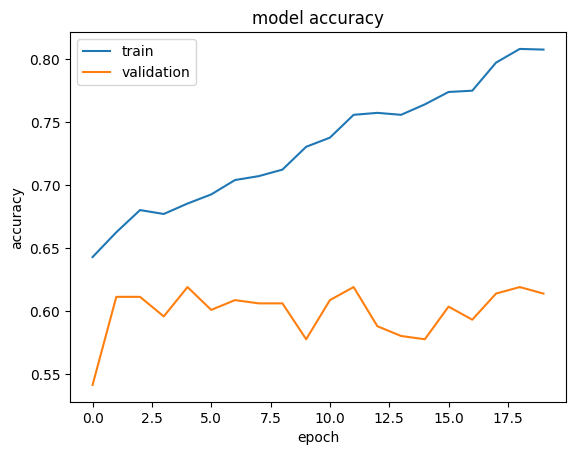

In [ ]:
plot_accuracy(history_efficientnetV2S_512_enhanced)

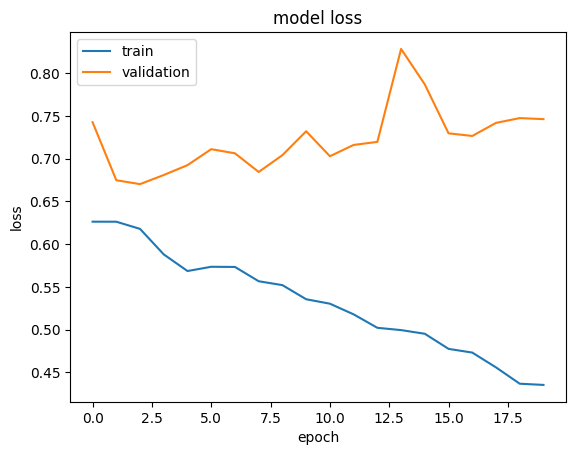

In [ ]:
plot_loss(history_efficientnetV2S_512_enhanced)

In [ ]:
enhanced_512_predicted_probabilities = model_efficientnetV2S_512_enhanced.predict(test_ds_512)
enhanced_512_true_labels = extract_true_labels(test_ds_512)

13/13 [==============================] - 10s 560ms/step


In [ ]:
enhanced_512_predicted_labels = extract_predicted_labels(enhanced_512_predicted_probabilities, 0.46)

In [ ]:
evaluation_metrics(enhanced_512_true_labels, enhanced_512_predicted_labels)

F1 score: 0.5905292479108635
Accuracy: 0.6191709844559585
Precision: 0.6191709844559585
Recall: 0.5492227979274611


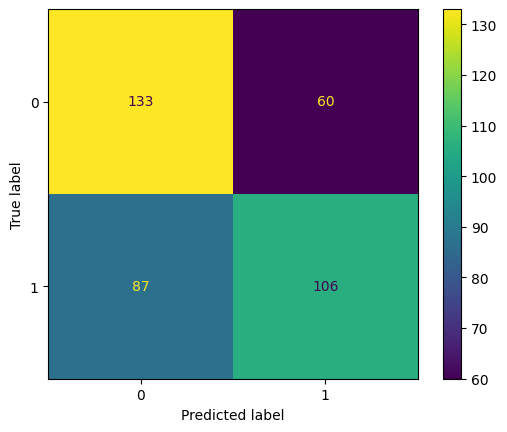

In [ ]:
display_confusion_matrix(enhanced_512_true_labels, enhanced_512_predicted_labels)

In [ ]:
y_pred_keras = enhanced_512_predicted_probabilities.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(enhanced_512_true_labels, y_pred_keras)
print(y_pred_keras)
enhanced_512_predicted_probabilities


[0.00279775 0.12635821 0.40918595 0.5849762  0.6479827  0.18173279
 0.36357936 0.48827827 0.72823846 0.15037034 0.14346476 0.18371145
 0.329176   0.5247995  0.15513337 0.24687523 0.36769906 0.17670563
 0.1833764  0.1765125  0.2591415  0.76242036 0.13893303 0.07360067
 0.41254634 0.7654746  0.07774169 0.33951122 0.06194922 0.33208597
 0.61023563 0.48300648 0.2121306  0.1272484  0.7643828  0.7287047
 0.08297034 0.30502006 0.06637901 0.65724516 0.34909377 0.04203883
 0.06347219 0.4434148  0.63004875 0.14897898 0.3778092  0.5773915
 0.5516065  0.36722723 0.31840897 0.5796301  0.3023894  0.30565354
 0.07531651 0.9734448  0.15195155 0.40415496 0.13563795 0.05226226
 0.64722687 0.40927973 0.6384799  0.17249514 0.15514922 0.15943176
 0.44285402 0.7505542  0.2781087  0.6407414  0.57768416 0.5172395
 0.5399769  0.18193573 0.425558   0.7339523  0.316403   0.07985759
 0.44750676 0.17372969 0.0817851  0.05495795 0.27889076 0.9028576
 0.45011145 0.6427995  0.44518742 0.1406034  0.10092781 0.16282415

array([[0.00279775],
       [0.12635821],
       [0.40918595],
       [0.5849762 ],
       [0.6479827 ],
       [0.18173279],
       [0.36357936],
       [0.48827827],
       [0.72823846],
       [0.15037034],
       [0.14346476],
       [0.18371145],
       [0.329176  ],
       [0.5247995 ],
       [0.15513337],
       [0.24687523],
       [0.36769906],
       [0.17670563],
       [0.1833764 ],
       [0.1765125 ],
       [0.2591415 ],
       [0.76242036],
       [0.13893303],
       [0.07360067],
       [0.41254634],
       [0.7654746 ],
       [0.07774169],
       [0.33951122],
       [0.06194922],
       [0.33208597],
       [0.61023563],
       [0.48300648],
       [0.2121306 ],
       [0.1272484 ],
       [0.7643828 ],
       [0.7287047 ],
       [0.08297034],
       [0.30502006],
       [0.06637901],
       [0.65724516],
       [0.34909377],
       [0.04203883],
       [0.06347219],
       [0.4434148 ],
       [0.63004875],
       [0.14897898],
       [0.3778092 ],
       [0.577

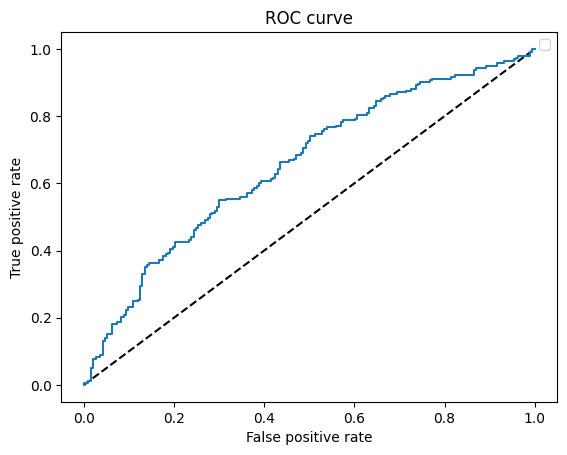

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
 idx = np.argmax(tpr_keras - fpr_keras)
 thresholds_keras[idx]

0.46819267

## **DenseNet121**

Resolution 256 unprocessed

In [ ]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds_256_unprocessed,  validation_data = test_ds_256, epochs = 30, batch_size = 64, class_weight=class_weight,  callbacks=[callback])

In [ ]:
model = unfreeze_model(model, "Adam", nb_unfrozen_layers=12, learning_rate=1e-4)

In [ ]:
hist = model.fit(train_ds_256_unprocessed, epochs=30, validation_data=test_ds_256, verbose=2)

In [ ]:
plot_accuracy(model)
plot_loss(model)

In [ ]:
densenet_probabilities = model.predict(test_ds_256)
true_labels = extract_true_labels(test_ds_256)

13/13 [==============================] - 7s 134ms/step


In [ ]:
densenet_predicted_labels = extract_predicted_labels(densenet_probabilities, 0.5)

In [ ]:
display_confusion_matrix(true_labels, densenet_predicted_labels)

In [ ]:
evaluation_metrics(true_labels, densenet_predicted_labels)